## Deep Learning

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
import pandas as pd
data=pd.read_csv('/content/gdrive/MyDrive/train-balanced-sarcasm.csv')
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [13]:
data.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [14]:
data['comment']=data['comment'].fillna('No Comment')

In [15]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [16]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
           sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [19]:
data['comment']=preprocess(data['comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:27<00:00, 37316.42it/s]


In [20]:
data['parent_comment']=preprocess(data['parent_comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:34<00:00, 29144.87it/s]


In [21]:
data.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [22]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Polarity Score

In [23]:
import nltk
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['parent_comment'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [24]:
data['compound'],data['negative'],data['positive'],data['neutral']=generate_sentiment_scores(data)

100%|██████████| 1010826/1010826 [04:45<00:00, 3538.73it/s]


In [25]:
data['com_len']=data['comment'].apply(lambda x:len(x.split()))

In [26]:
data['parent_com_len']=data['parent_comment'].apply(lambda x:len(x.split()))

In [27]:
data['comment']=data['comment']+" "+data['author']+" "+data['subreddit']

In [28]:
labels=tf.keras.utils.to_categorical(data['label'].values,num_classes=2)
labels.shape

(1010826, 2)

In [29]:
y=data['label']
X=data.drop(['label','date','created_utc'],axis=1)

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,labels,test_size=0.3,random_state=42,stratify=labels)

In [31]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
def text_padding(train,test,max_len):
    vocab=5000
    token=Tokenizer()
    token.fit_on_texts(train)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    return padded_train_text,padded_test_text,token

In [33]:
comm_len=200
train_com_pad,test_com_pad,token_com= text_padding(X_train['comment'],X_test['comment'],comm_len)

In [34]:
print(train_com_pad.shape,test_com_pad.shape)

(707578, 200) (303248, 200)


In [35]:
par_comm_len=200
train_par_com_pad,test_par_com_pad,token_par= text_padding(X_train['parent_comment'],X_test['parent_comment'],par_comm_len)

In [36]:
print(train_par_com_pad.shape,test_par_com_pad.shape)

(707578, 200) (303248, 200)


In [60]:
def generate_embedding_matrix(token):
    embedding_path='/content/gdrive/MyDrive/crawl-300d-2M.vec'
    embedding_size=300
    vocab_size=5000
    embedding_index={}
    with open(embedding_path, 'r') as f:
         for line in f:
             values = line.rstrip().rsplit(' ')
             word = values[0]
             coefs = np.asarray(values[1:], dtype='float32')
             embedding_index[word] = coefs
    num_words = len(token.word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_size))
    for word, i in token.word_index.items():
       embedding_vector = embedding_index.get(word)
       if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [61]:
embedding_comm = generate_embedding_matrix(token_com)
embedding_P_comm = generate_embedding_matrix(token_par)
print(embedding_comm.shape,embedding_P_comm.shape)

(362500, 300) (189737, 300)


In [39]:
print(embedding_comm[5])

[-0.0858     -0.0891      0.36210001  0.1354      0.0328     -0.0401
 -0.1109      0.15270001  0.0579     -0.066       0.146       0.1631
  0.019      -0.1365     -0.0306     -0.149      -0.0703     -0.1155
 -0.0633      0.0541      0.1996      0.0136     -0.19670001  0.0767
  0.1056     -0.19329999  0.21359999  0.1129      0.0035      0.1137
 -0.1462     -0.0073      0.16670001 -0.0324     -0.0151     -0.25780001
  0.1355      0.0447      0.0254      0.0636      0.0046      0.60579997
  0.0593      0.2617     -0.0703      0.1794      0.0162      0.0687
 -0.0143      0.4391      0.1102     -0.4725      0.639       0.1205
 -0.0424      0.0464     -0.0264     -0.0834     -0.0796      0.0671
 -0.0557     -0.26249999 -0.0105     -0.24439999  0.091       0.1649
  0.0192     -0.1514      0.0257     -0.24590001 -0.16230001  0.0352
  0.0938      0.3082      0.0809     -0.2626     -0.75919998 -0.0895
  0.1867     -0.0548      0.47150001  0.0264     -0.0358     -0.1159
 -0.1213     -0.0519      

In [40]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_score=trans.fit_transform(X_train['score'].values.reshape(-1,1))
X_test_score=trans.transform(X_test['score'].values.reshape(-1,1))

CPU times: user 13.7 ms, sys: 1.03 ms, total: 14.7 ms
Wall time: 14.4 ms


In [41]:
%%time
trans = Normalizer()
X_train_ups=trans.fit_transform(X_train['ups'].values.reshape(-1,1))
X_test_ups=trans.transform(X_test['ups'].values.reshape(-1,1))

CPU times: user 13.6 ms, sys: 23 µs, total: 13.6 ms
Wall time: 13 ms


In [42]:
%%time
trans = Normalizer()
X_train_downs=trans.fit_transform(X_train['downs'].values.reshape(-1,1))
X_test_downs=trans.transform(X_test['downs'].values.reshape(-1,1))

CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 15.8 ms


In [43]:
%%time
trans = Normalizer()
X_train_comp=trans.fit_transform(X_train['compound'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['compound'].values.reshape(-1,1))

CPU times: user 17.1 ms, sys: 4.02 ms, total: 21.2 ms
Wall time: 20.6 ms


In [44]:
%%time
trans = Normalizer()
X_train_neg=trans.fit_transform(X_train['negative'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['negative'].values.reshape(-1,1))

CPU times: user 19.7 ms, sys: 1.99 ms, total: 21.6 ms
Wall time: 21.1 ms


In [45]:
%%time
trans = Normalizer()
X_train_pos=trans.fit_transform(X_train['positive'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['positive'].values.reshape(-1,1))

CPU times: user 20.2 ms, sys: 1.97 ms, total: 22.2 ms
Wall time: 21.2 ms


In [46]:
%%time
trans = Normalizer()
X_train_neu=trans.fit_transform(X_train['neutral'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neutral'].values.reshape(-1,1))

CPU times: user 14.3 ms, sys: 2.02 ms, total: 16.4 ms
Wall time: 15.5 ms


In [47]:
%%time
trans = Normalizer()
X_train_com_len=trans.fit_transform(X_train['com_len'].values.reshape(-1,1))
X_test_com_len=trans.transform(X_test['com_len'].values.reshape(-1,1))

CPU times: user 10.6 ms, sys: 3.96 ms, total: 14.5 ms
Wall time: 13.7 ms


In [48]:
%%time
trans = Normalizer()
X_train_parent_com_len=trans.fit_transform(X_train['parent_com_len'].values.reshape(-1,1))
X_test_parent_com_len=trans.transform(X_test['parent_com_len'].values.reshape(-1,1))

CPU times: user 12.4 ms, sys: 2.03 ms, total: 14.4 ms
Wall time: 13.7 ms


In [62]:
numerical_train=np.concatenate((X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neu,X_train_neg,X_train_pos,X_train_com_len,X_train_parent_com_len),axis=1)
numerical_test=np.concatenate((X_test_score,X_test_ups,X_test_downs,X_test_comp,X_test_neu,X_test_neg,X_test_pos,X_test_com_len,X_test_parent_com_len),axis=1)

In [63]:
print(numerical_train.shape,numerical_test.shape)

(707578, 9) (303248, 9)


In [64]:
X_train=[train_com_pad,train_par_com_pad,numerical_train]
X_test=[test_com_pad,test_par_com_pad,numerical_test]

# **Model:-1**

LSTM layer Using Pre-Trained FasttextEmbedding

In [65]:
from tensorflow.keras.layers import concatenate
def LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [66]:
model4=LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm)
model4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     108750000   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 300)     56921100    parent_comment[0][0]             
____________________________________________________________________________________________

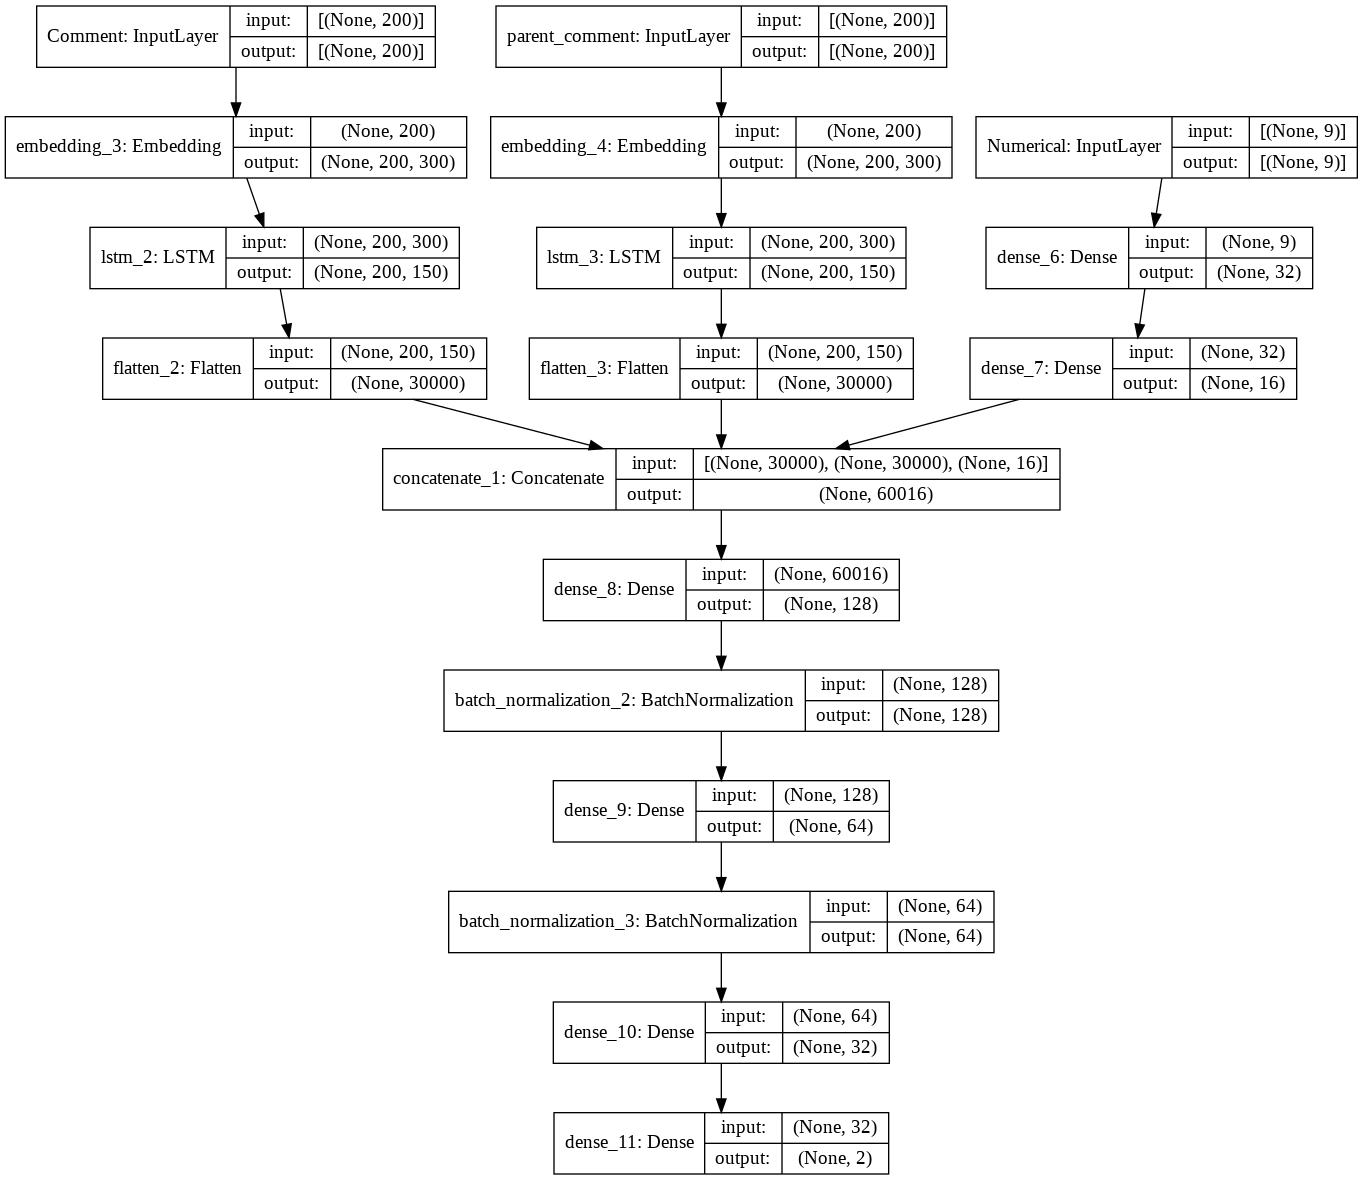

In [67]:
tf.keras.utils.plot_model(
    model4, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [69]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_4.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 5,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [70]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model4.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [71]:
hitory4=model4.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 249s 177ms/step - loss: 2.1983 - accuracy: 0.6939 - val_loss: 7.5074 - val_accuracy: 0.5000

Epoch 00001: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 254s 183ms/step - loss: 1.3957 - accuracy: 0.7226 - val_loss: 3.0642 - val_accuracy: 0.5000

Epoch 00002: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 254s 184ms/step - loss: 1.0722 - accuracy: 0.7318 - val_loss: 9.0586 - val_accuracy: 0.5000

Epoch 00003: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 4/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.6771 - accuracy: 0.7466 - val_loss: 1.1925 - val_accuracy: 0.5097

Epoch 00004: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 5/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.5812 - accuracy: 0.7520 - val_loss: 1.4110 - val_accuracy: 0.5000

Epoch 00005: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 6/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.5593 - accuracy: 0.7554 - val_loss: 1.7894 - val_accuracy: 0.5000

Epoch 00006: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 7/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.4967 - accuracy: 0.7620 - val_loss: 0.6517 - val_accuracy: 0.6847

Epoch 00007: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 8/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.4946 - accuracy: 0.7634 - val_loss: 2.2504 - val_accuracy: 0.5000

Epoch 00008: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 9/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.4931 - accuracy: 0.7646 - val_loss: 3.6071 - val_accuracy: 0.5000

Epoch 00009: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 10/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.4820 - accuracy: 0.7674 - val_loss: 0.7044 - val_accuracy: 0.6341

Epoch 00010: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 11/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4805 - accuracy: 0.7685 - val_loss: 1.3461 - val_accuracy: 0.5242

Epoch 00011: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00011: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 12/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4785 - accuracy: 0.7686 - val_loss: 0.5354 - val_accuracy: 0.7364

Epoch 00012: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 13/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4779 - accuracy: 0.7691 - val_loss: 0.6437 - val_accuracy: 0.6695

Epoch 00013: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 14/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4775 - accuracy: 0.7694 - val_loss: 0.5990 - val_accuracy: 0.6971

Epoch 00014: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
Epoch 15/50
1382/1382 [==============================] - 255s 185ms/step - loss: 0.4762 - accuracy: 0.7699 - val_loss: 0.5233 - val_accuracy: 0.7418

Epoch 00015: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 16/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4764 - accuracy: 0.7706 - val_loss: 0.5186 - val_accuracy: 0.7462

Epoch 00016: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 17/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4757 - accuracy: 0.7708 - val_loss: 0.5185 - val_accuracy: 0.7456

Epoch 00017: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 18/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4755 - accuracy: 0.7705 - val_loss: 0.5181 - val_accuracy: 0.7454

Epoch 00018: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00018: ReduceLROnPlateau reducing learning rate to 2.441406195430318e-06.
Epoch 19/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4756 - accuracy: 0.7700 - val_loss: 0.5169 - val_accuracy: 0.7465

Epoch 00019: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 20/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4753 - accuracy: 0.7703 - val_loss: 0.5164 - val_accuracy: 0.7469

Epoch 00020: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 21/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.4755 - accuracy: 0.7706 - val_loss: 0.5169 - val_accuracy: 0.7468

Epoch 00021: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 22/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.4754 - accuracy: 0.7710 - val_loss: 0.5179 - val_accuracy: 0.7458

Epoch 00022: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.103515488575795e-07.
Epoch 23/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.4752 - accuracy: 0.7706 - val_loss: 0.5171 - val_accuracy: 0.7463

Epoch 00023: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 24/50
1382/1382 [==============================] - 254s 184ms/step - loss: 0.4752 - accuracy: 0.7708 - val_loss: 0.5172 - val_accuracy: 0.7463

Epoch 00024: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5258788721439487e-07.
Epoch 25/50
1382/1382 [==============================] - 255s 184ms/step - loss: 0.4751 - accuracy: 0.7707 - val_loss: 0.5173 - val_accuracy: 0.7463

Epoch 00025: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 00025: early stopping


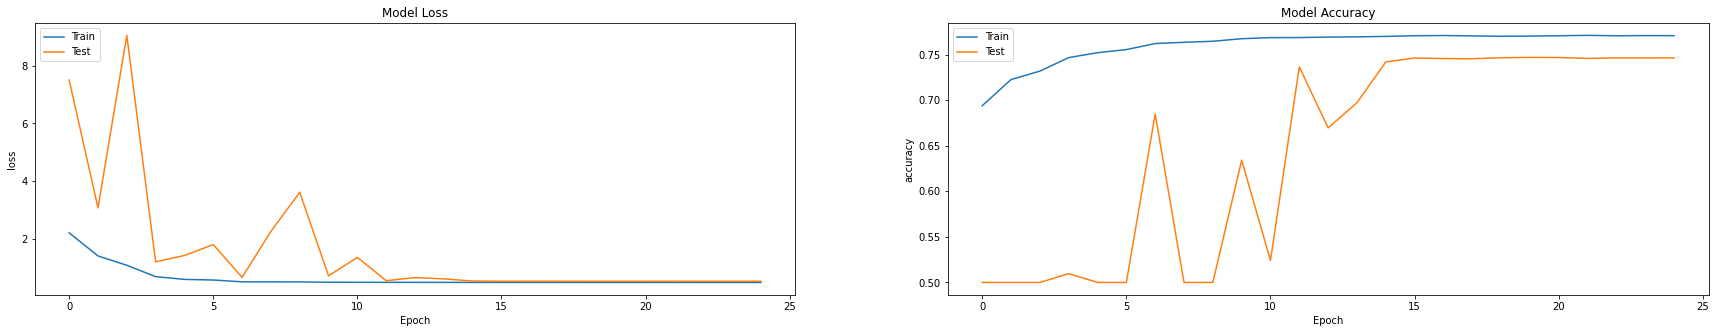

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory4.history['loss'])
plt.plot(hitory4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory4.history['accuracy'])
plt.plot(hitory4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()